In [6]:
#构建输出
import logging
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#构建corpus
import os
path ="D:/毕业设计/abstract_data/"  # 待处理的数据

fileList = os.listdir(path)
docs = [] #文档集合
for file in fileList:
    filePath = os.path.join(path, file)
    f = open(filePath, encoding='utf-8')
    content = f.read()
    f.close()
    docs.append(content)
docs = docs[:10000]
print(len(docs))

# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer
from tqdm.notebook import tqdm
# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')
for idx in tqdm(range(len(docs))):
    docs[idx] = docs[idx].lower()  # Convert to lowercase.
    docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
docs = [[token for token in doc if not token.isnumeric()] for doc in docs]

# Remove words that are only one character.
docs = [[token for token in doc if len(token) > 1] for doc in docs]


# Lemmatize the documents.
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]


# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 20 times or more).
bigram = Phrases(docs, min_count=20)
for idx in tqdm(range(len(docs))):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
corpus = [" ".join(doc) for doc in docs]

10000


  0%|          | 0/10000 [00:00<?, ?it/s]

2022-04-23 14:37:55,712 : INFO : collecting all words and their counts
2022-04-23 14:37:55,713 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2022-04-23 14:37:56,895 : INFO : collected 328402 word types from a corpus of 854528 words (unigram + bigrams) and 10000 sentences
2022-04-23 14:37:56,896 : INFO : using 328402 counts as vocab in Phrases<0 vocab, min_count=20, threshold=10.0, max_vocab_size=40000000>


  0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_tfidf = TfidfVectorizer(use_idf=True) # 构建tf-idf向量
X_tfidf = vectorizer_tfidf.fit_transform(corpus)

print(X_tfidf.shape)

(10000, 1642)


In [12]:
# 进行SVD降维处理
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

print("Performing dimensionality reduction using LSA")
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD(5000)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X_tfidf_lsa = lsa.fit_transform(X_tfidf)

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
    int(explained_variance * 100)))

print(X_tfidf_lsa.shape)

Performing dimensionality reduction using LSA
Explained variance of the SVD step: 68%
(10000, 100)


In [14]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
# 降维，minbatch? 2*2 = 4种
minikm_X_tfidf_lsa = MiniBatchKMeans(n_clusters=10, init='k-means++', n_init=1, init_size=1000, batch_size=1000, verbose=False)
minikm_X_tfidf_lsa.fit(X_tfidf_lsa)

minikm_X_tfidf = MiniBatchKMeans(n_clusters=10, init='k-means++', n_init=1, init_size=1000, batch_size=1000, verbose=False)
minikm_X_tfidf.fit(X_tfidf)

km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1, verbose=False)
km_X_tfidf_lsa = km.fit(X_tfidf_lsa)

km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1, verbose=False)
km_X_tfidf = km.fit(X_tfidf)

D:\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1044: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  "MiniBatchKMeans is known to have a memory leak on "


In [30]:
#这里要重新处理一下，没有降维过后的数据是稀疏的，无法进行后两个指标的评价
from sklearn import metrics


Xs = [X_tfidf_lsa,X_tfidf, X_tfidf_lsa, X_tfidf]

for index, method in enumerate([minikm_X_tfidf_lsa, minikm_X_tfidf, km_X_tfidf_lsa, km_X_tfidf]):
    X = Xs[index]
    print("Silhouette Coefficient: %0.3f"
          % metrics.silhouette_score(X, method.labels_, metric='euclidean'))
    print("Calinski-Harabaz: %0.3f"
          % metrics.calinski_harabasz_score(X, method.labels_))
    print(" Davies-Bouldin Index: %0.3f"
          % metrics.davies_bouldin_score(X, method.labels_))

   
    print("----------------------------------------------------------------")


Silhouette Coefficient: 0.347


AttributeError: 'list' object has no attribute 'toarray'

In [31]:
# minikm-tfidf-lsa
print("Top terms per cluster:")
original_space_centroids = svd.inverse_transform(minikm_X_tfidf_lsa.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]
terms = vectorizer_tfidf.get_feature_names()

for i in range(10):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()


Top terms per cluster:
Cluster 0: member read airbnb check also see something atlanta over about
Cluster 1: the data thanks stock good multiphysics among over first about
Cluster 2: amazon multiphysics company find among something thanks good washington plus
Cluster 3: chicago twitch during since welcome samuel end tesla not washington
Cluster 4: like it in if but we for today where delivering
Cluster 5: that have j99news something twitch visit san instead company chicago
Cluster 6: you although company first since end many read once like
Cluster 7: please starting disclaimer et twitch chicago over although end delivering
Cluster 8: this ve those san of image j99news yet good slideshare
Cluster 9: apple although data stock over yet disclaimer san airbnb member


D:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [32]:
result = list(minikm_X_tfidf.predict(X_tfidf))
print ('Cluster distribution:')
print (dict([(i, result.count(i)) for i in result]))
print(-minikm_X_tfidf.score(X_tfidf))

Cluster distribution:
{9: 7143, 4: 510, 0: 127, 3: 1250, 2: 137, 8: 94, 7: 176, 1: 137, 5: 220, 6: 206}
6949.1970685141


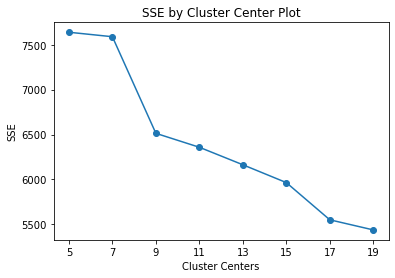

In [34]:
import matplotlib.pyplot as plt
def find_optimal_clusters(data, max_k):
    iters = range(5, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init="k-means++", init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(X_tfidf, 20)